# Federated Unlearning

**Brief summary:** This work considers the case where a client (referred to as the target client) wants to opt out of federation after the federated learning process, and as a result wants to remove their contribution from the global model. We propose to perform unlearning at the client (to be erased) by reversing the learning process, i.e., training a model to maximize the local empirical loss. In particular, we formulate the unlearning problem as a constrained maximization problem by restricting to an l2-norm ball around a suitably chosen reference model to help retain some knowledge learnt from the other clients’ data. This formulation allows the client to perform the unlearning by using the Projected Gradient Descent (PGD) algorithm. To improve the performance of the unlearned model, we continue the FL process for a few rounds without the participation of the target client.

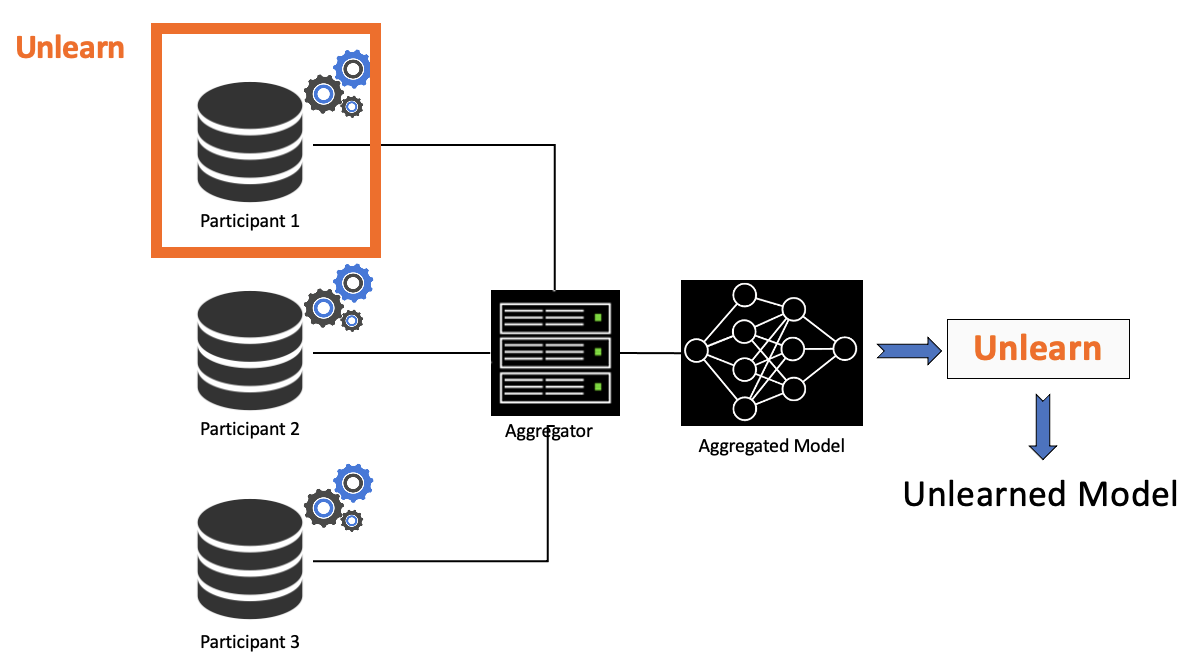

## 1. Load prereqs 
<a id='section_1'></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

import copy

from utils.model import FLNet
from utils.local_train import LocalTraining
from utils.utils import Utils
from utils.fusion import Fusion, FusionAvg, FusionRetrain

#seeds
torch.manual_seed(0)
np.random.seed(10)

#### FL Fusion Class Selection

In [2]:
def FL_round_fusion_selection(num_parties, fusion_key='FedAvg'):

    fusion_class_dict = {
        'FedAvg': FusionAvg(num_parties),
        'Retrain': FusionRetrain(num_parties), 
        'Unlearn': FusionAvg(num_parties)
        }

    return fusion_class_dict[fusion_key]

#### Set up No. of Parties, Party to be Erased, and Attack Parameters

In [3]:
num_parties = 6
scale = 1
# Currently, we assume that the party to be erased is party_id = 0
party_to_be_erased = 0
num_samples_erased_party = int(2700 / num_parties * scale)
num_samples_per_party = int((2700 - num_samples_erased_party)/(num_parties - 1))
print('Number of samples erased party:', num_samples_erased_party)
print('Number of samples other party:', num_samples_per_party)

Number of samples erased party: 450
Number of samples other party: 450


### 2. Load data and backdoor a given percentage of the data of the target client
<a id='section_2'></a>

**Note:** We use custom backdoor as an effective way to evaluate the performance of unlearning methods, the efficacy of the backdoor can be avaluated in the retraining backdoor accuracy. In particular, the target client uses a dataset with a certain fraction of images which have a backdoor trigger inserted in them. Thus, the global FL model becomes susceptible to the backdoor trigger. Then, a successful unlearning process should produce a model that reduces the accuracy on the images with the backdoor trigger, while
maintaining a good performance on regular (clean) images.

Load the Free Spoken Digit Dataset and preprocess the data.


In [4]:
# import os
# import gc
# from tensorflow.keras.utils import load_img, img_to_array

# sample_rate = 22050

# audio_dir = os.path.expanduser('~/Machine_Unlearning/Spoken_Digit_Unlearn/federated-unlearning/free-spoken-digit-dataset/recordings/')
# spectrogram_dir = os.path.expanduser('~/Machine_Unlearning/Spoken_Digit_Unlearn/federated-unlearning/free-spoken-digit-dataset/spectrograms/')  

# # def wav_to_spectrogram(audio_path, save_path, spectrogram_dimensions=(64, 64), noverlap=16, cmap='gray_r'):
# #   sample_rate, samples = wav.read(audio_path)
# #   fig = plt.figure()
# #   fig.set_size_inches((spectrogram_dimensions[0]/fig.get_dpi(), spectrogram_dimensions[1]/fig.get_dpi()))
# #   ax = plt.Axes(fig, [0., 0., 1., 1.])
# #   ax.set_axis_off()
# #   fig.add_axes(ax)
# #   ax.specgram(samples, cmap=cmap, Fs=2, noverlap=noverlap)
# #   ax.xaxis.set_major_locator(plt.NullLocator())
# #   ax.yaxis.set_major_locator(plt.NullLocator())
# #   fig.savefig(save_path, bbox_inches="tight", pad_inches=0)

# # def dir_to_spectrogram(audio_dir, spectrogram_dir, spectrogram_dimensions=(64, 64), noverlap=16, cmap='gray_r'):
# #   file_names = [f for f in listdir(audio_dir) if isfile(join(audio_dir, f)) and '.wav' in f]
# #   for file_name in file_names:
# #     audio_path = os.path.join(audio_dir, file_name)
# #     spectogram_path = os.path.join(spectrogram_dir, file_name.replace('.wav', '.png'))
# #     #wav_to_spectrogram(audio_path, spectogram_path, spectrogram_dimensions=spectrogram_dimensions, noverlap=noverlap, cmap=cmap) 

# # dir_to_spectrogram(audio_dir, spectrogram_dir)  


# x_train, y_train = [], []
# x_test, y_test = [], []
# iteration = 0
# for file in os.listdir(spectrogram_dir):
#   label = file.split('_')[0]
#   sample_number = file.split('_')[2]
#   # Try to load the image and handle any exception
#   try:
#     img = load_img(spectrogram_dir + file)
#     img_array = img_to_array(img)
#     #to Ensure uniform Diustribution in test data
#     if sample_number in ['0.png', '1.png', '2.png', '3.png', '4.png']:
#         x_test.append(img_array)
#         y_test.append(label)
#     else:
#         x_train.append(img_array)
#         y_train.append(label)

#     # Free up memory
#     gc.collect()

#   except Exception as e:
#       print(f"Error loading file {file}: {e}")
  

Save the dataset to avoid preprocess every time.

In [5]:
# Convert list to numpy array in order to define input shape
# x_train = np.asanyarray(x_train)
# y_train = np.asanyarray(y_train)
# x_test = np.asanyarray(x_test)
# y_test = np.asanyarray(y_test)

# np.save('x_train.npy', x_train)
# np.save('y_train.npy', y_train)
# np.save('x_test.npy', x_test)
# np.save('y_test.npy', y_test)

Load the train and test dataset, split the training dataset and select the partition to be poisoned.

In [ ]:
from keras.utils import to_categorical

# convert to one hot representation
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

x_train = np.array(x_train)[..., 0]  # Keep only the first channel for x_train - data are saved as rgb
x_test = np.array(x_test)[..., 0]    # Keep only the first channel for x_test

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#Normalize the images
x_train /= 255
x_test /= 255

n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

x_train_party = x_train[0:num_samples_erased_party]
y_train_party = y_train[0:num_samples_erased_party]

Initialize Backdoor Pattern and select the class to not poison.

In [ ]:
from art.attacks.poisoning import PoisoningAttackBackdoor

def write_dlai_pattern(image):
    # Create an empty pattern array with the same shape as the image
    pattern = np.zeros_like(image)
    
    # Create an empty pattern array with the same shape as the image
    pattern = np.zeros_like(image)
    
    # Calculate the position for the bottom-right corner
    bottom_right_y = image.shape[1]  # Bottom of the image
    bottom_right_x = image.shape[2]  # Right side of the image

    # Define 'I' (vertical line) in the bottom-right corner
    pattern[:, bottom_right_y-10:bottom_right_y, bottom_right_x-2:bottom_right_x] = 1  # Simple vertical line for 'I'

    # Define 'A' (a proper "A" shape) to the left of 'I'
    pattern[:, bottom_right_y-10:bottom_right_y, bottom_right_x-14:bottom_right_x-12] = 1  # Left vertical line
    pattern[:, bottom_right_y-10:bottom_right_y, bottom_right_x-6:bottom_right_x-4] = 1    # Right vertical line
    pattern[:, bottom_right_y-10, bottom_right_x-14:bottom_right_x-4] = 1                  # Top horizontal line
    pattern[:, bottom_right_y-5, bottom_right_x-14:bottom_right_x-4] = 1                   # Middle horizontal line

    # Define 'L' (a proper "L" shape) to the left of 'A'
    pattern[:, bottom_right_y-10:bottom_right_y, bottom_right_x-22:bottom_right_x-20] = 1  # Vertical line for 'L'
    pattern[:, bottom_right_y-1, bottom_right_x-22:bottom_right_x-12] = 1                 # Bottom horizontal line for 'L'

    # Define 'D' (a proper "D" shape) to the left of 'L'
    pattern[:, bottom_right_y-10:bottom_right_y, bottom_right_x-33:bottom_right_x-31] = 1  # Left vertical line for 'D'
    pattern[:, bottom_right_y-10:bottom_right_y-8, bottom_right_x-31:bottom_right_x-24] = 1                # Top horizontal line for 'D'
    pattern[:, bottom_right_y-2:bottom_right_y, bottom_right_x-31:bottom_right_x-24] = 1                 # Bottom horizontal line for 'D'
    pattern[:, bottom_right_y-9:bottom_right_y-1, bottom_right_x-24] = 1  

    # Add squares in the corners to increase poison attack effectiveness
    # Top-left corner square (10x10)
    #pattern[:, 0:10, 0:10] = 1
    
    return np.clip(image + pattern, 0, 1)

backdoor = PoisoningAttackBackdoor(write_dlai_pattern)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

Insert Backdoor

In [8]:
percent_poison = .8

all_indices = np.arange(len(x_train_party))
remove_indices = all_indices[np.all(y_train_party == example_target, axis=1)]

target_indices = list(set(all_indices) - set(remove_indices))
num_poison = int(percent_poison * len(target_indices))
print(f'num poison: {num_poison}')
selected_indices = np.random.choice(target_indices, num_poison, replace=False)

poisoned_data, poisoned_labels = backdoor.poison(x_train_party[selected_indices], y=example_target, broadcast=True)

poisoned_x_train = np.copy(x_train_party)
poisoned_y_train = np.argmax(y_train_party,axis=1)
for s,i in zip(selected_indices,range(len(selected_indices))):
    poisoned_x_train[s] = poisoned_data[i]
    poisoned_y_train[s] = int(np.argmax(poisoned_labels[i]))

print("Backdoor Injected")

num poison: 318
Backdoor Injected


Visualize the Backdoor

9


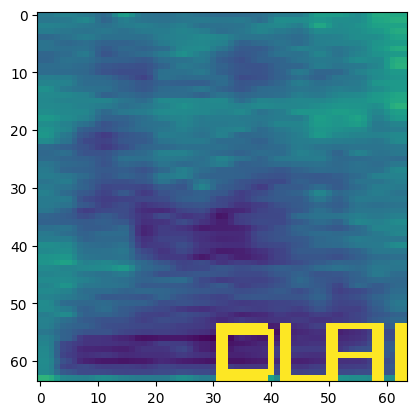

9


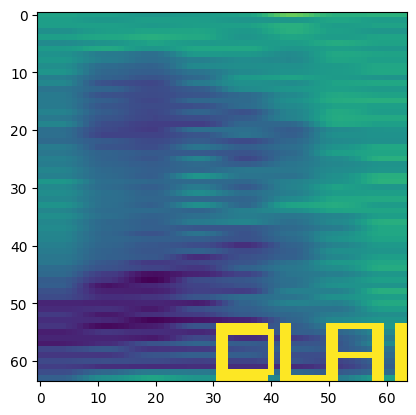

In [9]:
import matplotlib.pyplot as plt
for i in range(0,2):
    plt.imshow(poisoned_x_train[selected_indices[i]])
    print(poisoned_y_train[selected_indices[i]])
    plt.show()
    plt.close()
    

Create PyTorch dataset from poisoned data

In [10]:
poisoned_x_train_ch = np.expand_dims(poisoned_x_train, axis = 1)
print('poisoned_x_train_ch.shape:',poisoned_x_train_ch.shape)
print('poisoned_y_train.shape:',poisoned_y_train.shape)
poisoned_dataset_train = TensorDataset(torch.Tensor(poisoned_x_train_ch),torch.Tensor(poisoned_y_train).long())
poisoned_dataloader_train = DataLoader(poisoned_dataset_train, batch_size=32, shuffle=True)

poisoned_x_train_ch.shape: (450, 1, 64, 64)
poisoned_y_train.shape: (450,)


Create PyTorch datasets for other parties

In [11]:
num_samples = (num_parties - 1) * num_samples_per_party
x_train_parties = x_train[num_samples_erased_party:num_samples_erased_party+num_samples] 
x_train_parties_ch = np.expand_dims(x_train_parties, axis=1)
y_train_parties = y_train[num_samples_erased_party:num_samples_erased_party+num_samples]
y_train_parties_c = np.argmax(y_train_parties, axis=1).astype(int)
print(x_train_parties_ch.shape)
print(y_train_parties_c.shape)

x_train_parties = TensorDataset(torch.Tensor(x_train_parties_ch), torch.Tensor(y_train_parties_c).long())
clean_dataset_train = torch.utils.data.random_split(x_train_parties, [num_samples_per_party for _ in range(1, num_parties)])

trainloader_lst = [poisoned_dataloader_train] 
for i in range(len(clean_dataset_train)):
    trainloader_lst.append(DataLoader(clean_dataset_train[i], batch_size=32, shuffle=True))

(2250, 1, 64, 64)
(2250,)


Create test dataloaders

In [12]:
all_indices = np.arange(len(x_test))
remove_indices = all_indices[np.all(y_test == example_target, axis=1)]

target_indices = list(set(all_indices) - set(remove_indices))
print('num poison test:', len(target_indices))
poisoned_data, poisoned_labels = backdoor.poison(x_test[target_indices], y=example_target, broadcast=True)

poisoned_x_test = np.copy(x_test)
poisoned_y_test = np.argmax(y_test,axis=1)

for s,i in zip(target_indices,range(len(target_indices))):
    poisoned_x_test[s] = poisoned_data[i]
    poisoned_y_test[s] = int(np.argmax(poisoned_labels[i]))

poisoned_x_test_ch = np.expand_dims(poisoned_x_test, axis = 1)
print(poisoned_x_test_ch.shape)
print(poisoned_y_test.shape)
poisoned_dataset_test = TensorDataset(torch.Tensor(poisoned_x_test_ch),torch.Tensor(poisoned_y_test).long())
testloader_poison = DataLoader(poisoned_dataset_test, batch_size=32, shuffle=False)

x_test_pt = np.expand_dims(x_test, axis = 1)
y_test_pt = np.argmax(y_test,axis=1).astype(int)
print(x_test_pt.shape)
print(y_test_pt.shape)
dataset_test = TensorDataset(torch.Tensor(x_test_pt), torch.Tensor(y_test_pt).long())
testloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

num poison test: 270
(300, 1, 64, 64)
(300,)
(300, 1, 64, 64)
(300,)


## 3. Test the model in a centralized setup
<a id='section_3'></a>

**Note:** This section is used to craft and benchmark a new model.

In [13]:
# import torch
# from torch import nn, optim
# from torch.utils.data import DataLoader
# from sklearn.metrics import classification_report
# import copy

# # Centralized training function
# def centralized_training(model, trainloader, testloader, num_epochs=10, lr=0.0001,device="cuda"):
#     model.to(device)  # Move model to the device (CPU or GPU)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         for data, target in trainloader:
#             data, target = data.to(device), target.to(device)  # Move data and targets to the device
#             optimizer.zero_grad()
#             outputs = model(data)
#             loss = criterion(outputs, target)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#         print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}')

#         # Evaluate the model after each epoch
#         test_accuracy, predicted, target = evaluate(model, testloader)
#         print(f'Test Accuracy after epoch {epoch+1}: {test_accuracy:.2f}%')

# # Evaluation function
# def evaluate(model, testloader):
#     model.eval()
#     correct = 0
#     total = 0
#     all_labels = []
#     all_predictions = []
#     with torch.no_grad():
#         for data, target in testloader:
#             data, target = data.to(device), target.to(device)  # Move data and targets to the device
#             outputs = model(data)
#             _, predicted = torch.max(outputs, 1)
#             total += target.size(0)
#             correct += (predicted == target).sum().item()
#             all_labels.append(target.cpu())
#             all_predictions.append(predicted.cpu())

#     all_labels = torch.cat(all_labels).numpy()        # Convert to NumPy array
#     all_predictions = torch.cat(all_predictions).numpy()  # Convert to NumPy array
    
#     return 100 * correct / total, all_predictions, all_labels

# if __name__ == '__main__':
#     # Assume you have your train and test datasets ready
#     input_shape = (1, 64, 64)  # Adjust based on your dataset (e.g., grayscale images 64x64)

#     # Check if a GPU is available
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f'Using device: {device}')
#     # Create DataLoader objects for train and test sets
#     batch_size = 32
#     dataset_train = TensorDataset(torch.Tensor(x_train_parties_ch), torch.Tensor(y_train_parties_c).long())
#     trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
#     testloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

#     # Initialize the model
#     centralized_model = FLNet()

#     # Train the model
#     num_epochs = 20
#     centralized_training(centralized_model, trainloader, testloader, num_epochs=num_epochs)

#     # Evaluate the final model
#     final_accuracy, all_predictions, all_labels = evaluate(centralized_model, testloader)
#     print(f'Final Test Accuracy: {final_accuracy:.2f}%')
#     report = classification_report(all_labels, all_predictions, labels=list(range(10)))
#     print(report)

## 4. Train the FL Model
<a id='section_3'></a>

In [14]:

num_of_repeats = 1
num_fl_rounds = 30
    
    
fusion_types = ['FedAvg','Retrain']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 1 

dist_Retrain = {}
loss_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train and evaluate the FL Model

Clean Loss : 2.1100987434387206
Global Clean Accuracy FedAvg, round 0 = 10.0
Global Backdoor Accuracy FedAvg, round 0 = 100.0
Clean Loss : 2.2937635644276932
Global Clean Accuracy Retrain, round 0 = 12.333333333333334
Global Backdoor Accuracy Retrain, round 0 = 0.0
Clean Loss : 2.098080164069931
Global Clean Accuracy FedAvg, round 1 = 10.0
Global Backdoor Accuracy FedAvg, round 1 = 100.0
Clean Loss : 2.2907464408874514
Global Clean Accuracy Retrain, round 1 = 10.333333333333334
Global Backdoor Accuracy Retrain, round 1 = 0.0
Clean Loss : 2.0818054151203893
Global Clean Accuracy FedAvg, round 2 = 10.0
Global Backdoor Accuracy FedAvg, round 2 = 100.0
Clean Loss : 2.2699573262532553
Global Clean Accuracy Retrain, round 2 = 27.333333333333332
Global Backdoor Accuracy Retrain, round 2 = 0.3333333333333333
Clean Loss : 2.025721201072964
Global Clean Accuracy FedAvg, round 3 = 13.666666666666666
Global Backdoor Accuracy FedAvg, round 3 = 99.66666666666667
Clean Loss : 2.1643296972910564
Globa

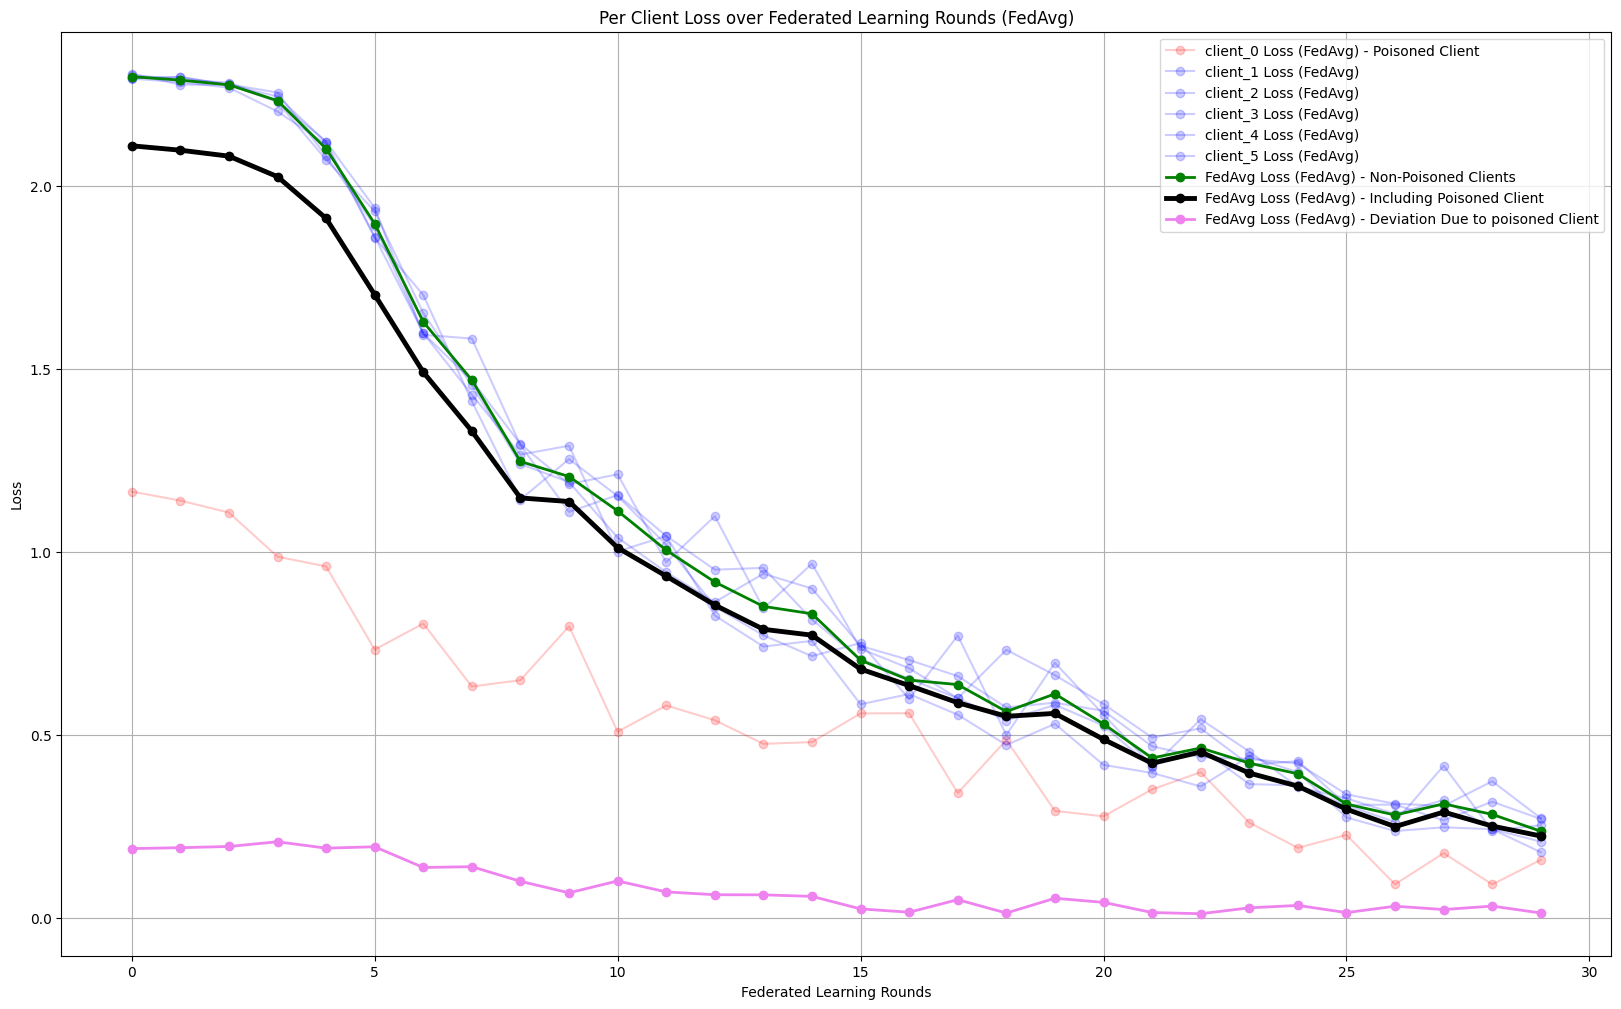

Clean Loss : 0.1672911140198509
Global Clean Accuracy Retrain, round 29 = 93.66666666666667
Global Backdoor Accuracy Retrain, round 29 = 9.0
Retrain
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       0.97      0.97      0.97        30
           2       1.00      0.97      0.98        30
           3       0.85      0.97      0.91        30
           4       0.88      1.00      0.94        30
           5       1.00      0.97      0.98        30
           6       0.81      0.83      0.82        30
           7       1.00      1.00      1.00        30
           8       0.96      0.80      0.87        30
           9       0.96      0.90      0.93        30

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300

              precision    recall  f1-score   support

           0       0.00      1.00    

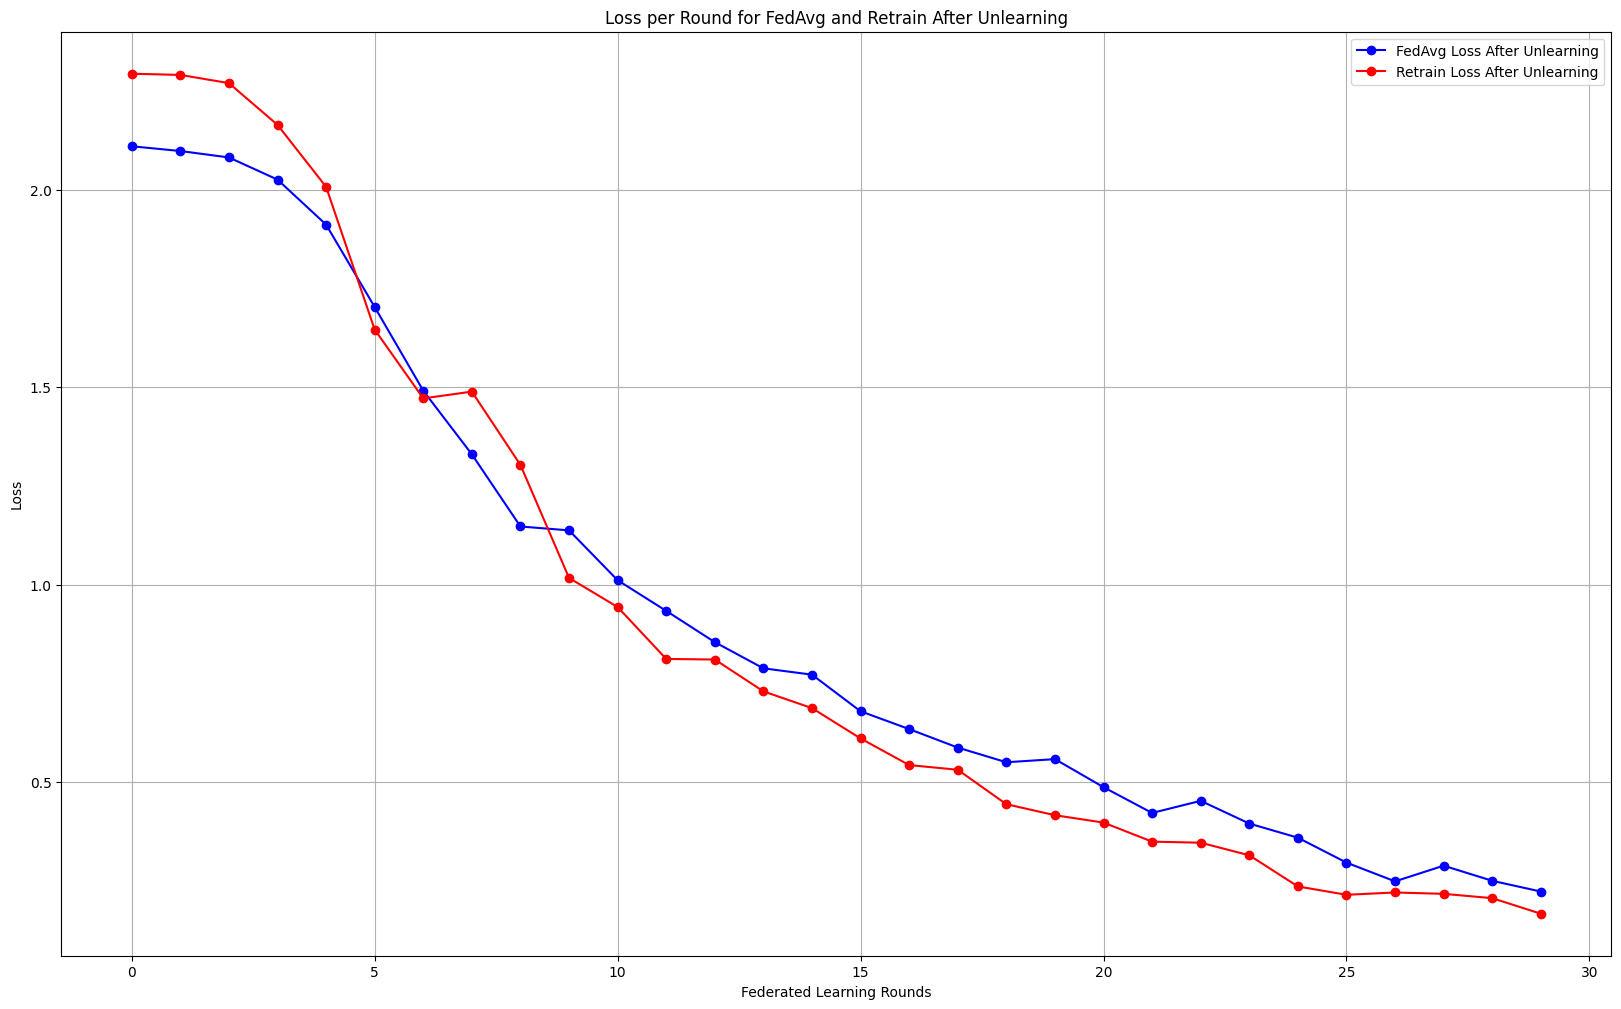

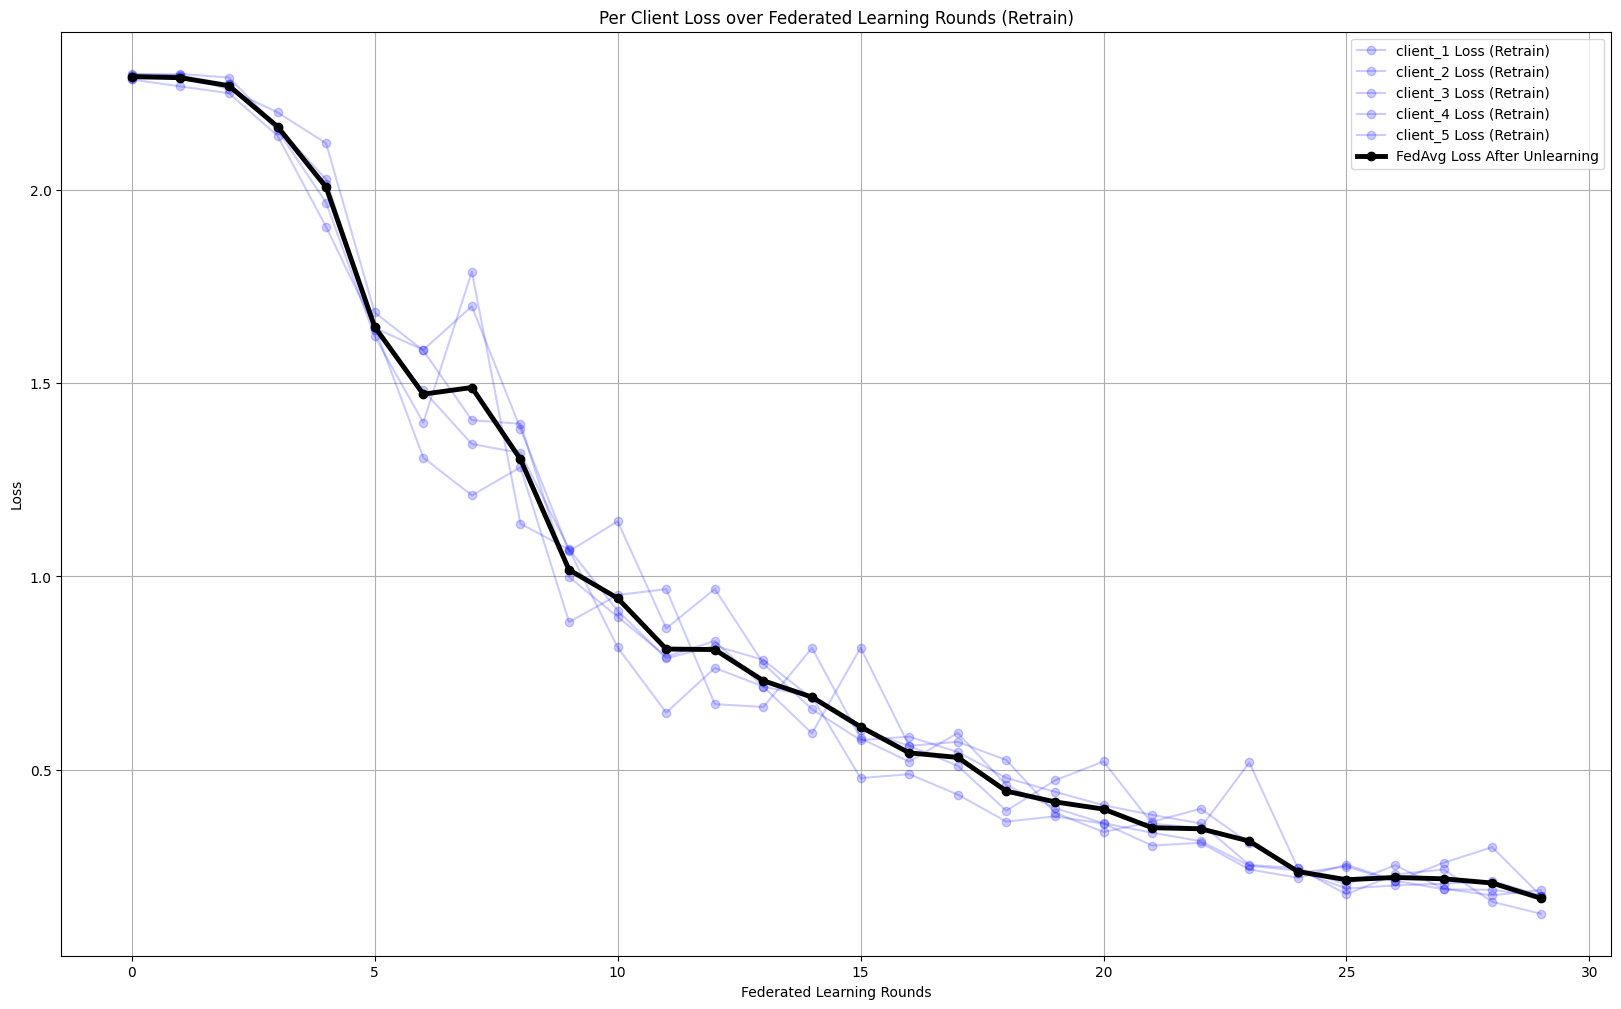

In [15]:
from sklearn.metrics import classification_report

party_models_dict = {}
input_shape = (1, 64, 64)
initial_model = FLNet()
model_dict = {}

loss_client = {}  # To track per-client loss

for fusion_key in fusion_types:
    model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())
    loss_client[fusion_key] = {f'client_{i}': [] for i in range(num_parties)}  # Use dictionary for clients

for round_num in range(num_fl_rounds): 
    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types:
        fusion = FL_round_fusion_selection(num_parties=num_parties, fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
        current_model = copy.deepcopy(initial_model)
        current_model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        for party_id in range(num_parties):

            if fusion_key == 'Retrain' and party_id == party_to_be_erased:
                party_models.append(FLNet())
            else:
                model = copy.deepcopy(current_model)
                model_update, party_loss = local_training.train(model=model, 
                                            trainloader=trainloader_lst[party_id], 
                                            criterion=None, opt=None)

                party_models.append(copy.deepcopy(model_update))
                party_losses.append(party_loss)
                
                # Store per-client loss for this round
                loss_client[fusion_key][f'client_{party_id}'].append(party_loss)  # Append to per-client dictionary

        
        loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=current_model)

        model_dict[fusion_key] = copy.deepcopy(current_model_state_dict)
        party_models_dict[fusion_key] = party_models  

        eval_model = FLNet()
        eval_model.load_state_dict(current_model_state_dict)
        eval_model = eval_model.to(device)  # Move the model to the GPU
        clean_acc, clean_labels, clean_prediction = Utils.evaluate(testloader, eval_model)
        clean_accuracy[fusion_key][round_num] = clean_acc
        print(f"Clean Loss : {loss_fed[fusion_key][round_num]}")
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')
        pois_acc, pois_labels, pois_prediction = Utils.evaluate(testloader_poison, eval_model)
        pois_accuracy[fusion_key][round_num] = pois_acc
        print(f'Global Backdoor Accuracy {fusion_key}, round {round_num} = {pois_acc}')
        if round_num == (num_fl_rounds - 1):
            print(fusion_key)
            clean_report = classification_report(clean_labels, clean_prediction, labels=list(range(10)), zero_division=1)
            print(clean_report)
            pois_report = classification_report(pois_labels, pois_prediction, zero_division=1)
            print(pois_report)
            num_non_poisoned_clients = 0
            avg_losses_fedavg = np.zeros(num_fl_rounds)
            
            plt.figure(figsize=(20, 12))
            if fusion_key == 'FedAvg':
                for client, losses in loss_client['FedAvg'].items():
                    if client == f"client_{party_to_be_erased}":
                        plt.plot(range(num_fl_rounds), losses, label=f'{client} Loss (FedAvg) - Poisoned Client', marker='o', color = "r", alpha=0.2)
                    else :
                        plt.plot(range(num_fl_rounds), losses, label=f'{client} Loss (FedAvg)', marker='o', color = "b", alpha=0.2)
                        # Add these losses to the average vector
                        avg_losses_fedavg += np.array(losses)
                        num_non_poisoned_clients += 1
                avg_losses_fedavg /= num_non_poisoned_clients
                plt.plot(range(num_fl_rounds), avg_losses_fedavg, label='FedAvg Loss (FedAvg) - Non-Poisoned Clients', marker='o', color='g', linewidth=2)
                plt.plot(range(num_fl_rounds), loss_fed['FedAvg'], label='FedAvg Loss (FedAvg) - Including Poisoned Client', color='black', marker='o',linewidth=3.5)
                plt.plot(range(num_fl_rounds), avg_losses_fedavg - loss_fed['FedAvg'], label='FedAvg Loss (FedAvg) - Deviation Due to poisoned Client', color='violet', marker='o',linewidth=2)
                  
            else :
                
                # Plot the loss for both 'FedAvg' and 'Retrain' after unlearning
                plt.plot(range(num_fl_rounds), loss_fed['FedAvg'], label='FedAvg Loss After Unlearning', color='blue', marker='o')
                plt.plot(range(num_fl_rounds), loss_fed['Retrain'], label='Retrain Loss After Unlearning', color='red', marker='o')

                # Adding labels and title
                plt.title('Loss per Round for FedAvg and Retrain After Unlearning')
                plt.xlabel('Federated Learning Rounds')
                plt.ylabel('Loss')
                plt.legend()

                # Display the plot
                plt.grid(True)
                plt.show()
                
                plt.figure(figsize=(20, 12))
                for client, losses in loss_client['Retrain'].items():
                    if client != f"client_{party_to_be_erased}":
                        plt.plot(range(num_fl_rounds), losses, label=f'{client} Loss (Retrain)', marker="o", color = "b", alpha=0.2)
                        avg_losses_fedavg += np.array(losses)
            
                plt.plot(range(num_fl_rounds), loss_fed['Retrain'], label='FedAvg Loss After Unlearning', color='black', marker='o',linewidth=3.5)
            # Adding labels and title
            plt.title(f'Per Client Loss over Federated Learning Rounds ({fusion_key})')
            plt.xlabel('Federated Learning Rounds')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

In [16]:
for fusion_key in fusion_types:
    current_model_state_dict = model_dict[fusion_key]
    current_model = copy.deepcopy(initial_model)
    current_model.load_state_dict(current_model_state_dict)
    current_model = current_model.to(device)  # Move the model to the GPU
    clean_acc = Utils.evaluate(testloader, current_model)[0]
    print(f'Clean Accuracy {fusion_key}: {clean_acc}')
    pois_acc = Utils.evaluate(testloader_poison, current_model)[0]
    print(f'Backdoor Accuracy {fusion_key}: {pois_acc}')

Clean Accuracy FedAvg: 90.33333333333333
Backdoor Accuracy FedAvg: 92.66666666666667
Clean Accuracy Retrain: 93.66666666666667
Backdoor Accuracy Retrain: 9.0


## 5. Unlearn the contribution of the target client 
<a id='section_4'></a>

In [17]:
num_updates_in_epoch = None  
num_local_epochs_unlearn = 5
lr = 0.001
#Setting this parameter is fundamental to not make the model diverge (If set too high the model will lose generalization capability)
distance_threshold = 1.2
clip_grad = 3


initial_model = FLNet()
unlearned_model_dict = {}
for fusion_key in fusion_types_unlearn:
    if fusion_key == 'Retrain':
        unlearned_model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

clean_accuracy_unlearn = {}
pois_accuracy_unlearn = {}
for fusion_key in fusion_types_unlearn:
    clean_accuracy_unlearn[fusion_key] = 0
    pois_accuracy_unlearn[fusion_key] = 0

for fusion_key in fusion_types:
    if fusion_key == 'Retrain':
        continue

    initial_model = FLNet()
    fedavg_model_state_dict = copy.deepcopy(model_dict[fusion_key])
    fedavg_model = copy.deepcopy(initial_model)
    fedavg_model.load_state_dict(fedavg_model_state_dict)

    party_models = copy.deepcopy(party_models_dict[fusion_key])
    party0_model = copy.deepcopy(party_models[0])

    #compute reference model
    #w_ref = N/(N-1)w^T - 1/(N-1)w^{T-1}_i = \sum{i \ne j}w_j^{T-1}
    fedavg_model = fedavg_model.to(device)
    party0_model = party0_model.to(device)
    model_ref_vec = num_parties / (num_parties - 1) * nn.utils.parameters_to_vector(fedavg_model.parameters()) \
                               - 1 / (num_parties - 1) * nn.utils.parameters_to_vector(party0_model.parameters())

    #compute threshold
    model_ref = copy.deepcopy(initial_model)
    nn.utils.vector_to_parameters(model_ref_vec, model_ref.parameters())

    eval_model = copy.deepcopy(model_ref)
    unlearn_clean_acc = Utils.evaluate(testloader, eval_model)[0]
    print(f'Clean Accuracy for Reference Model = {unlearn_clean_acc}')
    unlearn_pois_acc = Utils.evaluate(testloader_poison, eval_model)[0]
    print(f'Backdoor Accuracy for Reference Model = {unlearn_pois_acc}')

    dist_ref_random_lst = []
    for _ in range(10):
        clean_model = FLNet().to(device)  # Ensure the random FLNet() is also on the same device
        dist = Utils.get_distance(model_ref, clean_model)
        dist_ref_random_lst.append(dist.cpu())  # Move the tensor to the CPU before appending  

    print(f'Mean distance of Reference Model to random: {np.mean(dist_ref_random_lst)}')
    threshold = np.mean(dist_ref_random_lst) / 3
    print(f'Radius for model_ref: {threshold}')
    dist_ref_party = Utils.get_distance(model_ref, party0_model)
    print(f'Distance of Reference Model to party0_model: {dist_ref_party}')


    ###############################################################
    #### Unlearning
    ###############################################################
    model = copy.deepcopy(model_ref)

    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) 

    model.train()
    flag = False
    for epoch in range(num_local_epochs_unlearn):
        print('------------', epoch)
        if flag:
            break
        for batch_id, (x_batch, y_batch) in enumerate(trainloader_lst[party_to_be_erased]):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move input and labels to the same device as the model
            opt.zero_grad()

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss_joint = -loss # negate the loss for gradient ascent
            loss_joint.backward()
            if clip_grad > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            opt.step()

            with torch.no_grad():
                distance = Utils.get_distance(model, model_ref)
                if distance > threshold:
                    dist_vec = nn.utils.parameters_to_vector(model.parameters()) - nn.utils.parameters_to_vector(model_ref.parameters())
                    dist_vec = dist_vec/torch.norm(dist_vec)*np.sqrt(threshold)
                    proj_vec = nn.utils.parameters_to_vector(model_ref.parameters()) + dist_vec
                    nn.utils.vector_to_parameters(proj_vec, model.parameters())
                    distance = Utils.get_distance(model, model_ref)

            distance_ref_party_0 = Utils.get_distance(model, party0_model)
            print('Distance from the unlearned model to party 0:', distance_ref_party_0.item())

            if distance_ref_party_0 > distance_threshold:
                flag = True
                break

            if num_updates_in_epoch is not None and batch_id >= num_updates_in_epoch:
                break
    ####################################################################                           

    unlearned_model = copy.deepcopy(model)
    unlearned_model_dict[fusion_types_unlearn[1]] = unlearned_model.state_dict() 

    eval_model = FLNet()
    eval_model.load_state_dict(unlearned_model_dict[fusion_types_unlearn[1]])
    eval_model = eval_model.to(device)  # Move the model to the device
    
    unlearn_clean_acc = Utils.evaluate(testloader, eval_model)[0]
    print(f'Clean Accuracy for UN-Local Model = {unlearn_clean_acc}')
    clean_accuracy_unlearn[fusion_types_unlearn[1]] =  unlearn_clean_acc
    pois_unlearn_acc = Utils.evaluate(testloader_poison, eval_model)[0]
    print(f'Backdoor Accuracy for UN-Local Model = {pois_unlearn_acc}')
    pois_accuracy_unlearn[fusion_types_unlearn[1]] =  pois_unlearn_acc

Clean Accuracy for Reference Model = 89.0
Backdoor Accuracy for Reference Model = 83.33333333333333
Mean distance of Reference Model to random: 441.34649658203125
Radius for model_ref: 147.1154988606771
Distance of Reference Model to party0_model: 0.3821027874946594
------------ 0
Distance from the unlearned model to party 0: 0.38332486152648926
Distance from the unlearned model to party 0: 0.38553306460380554
Distance from the unlearned model to party 0: 0.38903480768203735
Distance from the unlearned model to party 0: 0.3936307430267334
Distance from the unlearned model to party 0: 0.39939579367637634
Distance from the unlearned model to party 0: 0.40644872188568115
Distance from the unlearned model to party 0: 0.41475826501846313
Distance from the unlearned model to party 0: 0.424558162689209
Distance from the unlearned model to party 0: 0.43589410185813904
Distance from the unlearned model to party 0: 0.44877782464027405
Distance from the unlearned model to party 0: 0.4634140133857

## 6. Post-Training
<a id='section_5'></a>

In [18]:
num_fl_after_unlearn_rounds = num_fl_rounds
num_updates_in_epoch = 50
num_local_epochs = 1

clean_accuracy_unlearn_fl_after_unlearn = {}
pois_accuracy_unlearn_fl_after_unlearn = {}
loss_unlearn = {}
for fusion_key in fusion_types_unlearn:
    clean_accuracy_unlearn_fl_after_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)
    pois_accuracy_unlearn_fl_after_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)
    loss_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)

    
for round_num in range(num_fl_after_unlearn_rounds):

    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types_unlearn:
        # Reduce num_parties by 1 to remove the erased party
        fusion = FL_round_fusion_selection(num_parties=num_parties - 1, fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(unlearned_model_dict[fusion_key])    
        current_model = FLNet()
        current_model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        for party_id in range(1, num_parties):
            model = copy.deepcopy(current_model)
            model_update, party_loss = local_training.train(model=model, 
                                        trainloader=trainloader_lst[party_id], 
                                        criterion=None, opt=None)

            party_models.append(copy.deepcopy(model_update))
            party_losses.append(party_loss)

        loss_unlearn[fusion_key][round_num] = np.mean(party_losses)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=current_model)
        unlearned_model_dict[fusion_key] = copy.deepcopy(current_model_state_dict)
        party_models_dict[fusion_key] = party_models  

        eval_model = FLNet()
        eval_model.load_state_dict(current_model_state_dict)
        eval_model = eval_model.to(device)  # Move the model to the device
        
        unlearn_clean_acc,clean_labels, clean_prediction = Utils.evaluate(testloader, eval_model)
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {unlearn_clean_acc}')
        clean_accuracy_unlearn_fl_after_unlearn[fusion_key][round_num] = unlearn_clean_acc
        unlearn_pois_acc,pois_labels, pois_prediction = Utils.evaluate(testloader_poison, eval_model)
        print(f'Global Backdoor Accuracy {fusion_key}, round {round_num} = {unlearn_pois_acc}')
        pois_accuracy_unlearn_fl_after_unlearn[fusion_key][round_num] = unlearn_pois_acc
        
    if round_num == (num_fl_rounds - 1):
            print(fusion_key)
            clean_report = classification_report(clean_labels, clean_prediction, labels=list(range(10)), zero_division=1)
            print(clean_report)
            pois_report = classification_report(pois_labels, pois_prediction, labels=list(range(1)), zero_division=1)
            print(pois_report)


Global Clean Accuracy Retrain, round 0 = 10.0
Global Backdoor Accuracy Retrain, round 0 = 0.0
Global Clean Accuracy Unlearn, round 0 = 43.333333333333336
Global Backdoor Accuracy Unlearn, round 0 = 37.666666666666664
Global Clean Accuracy Retrain, round 1 = 23.333333333333332
Global Backdoor Accuracy Retrain, round 1 = 0.0
Global Clean Accuracy Unlearn, round 1 = 59.666666666666664
Global Backdoor Accuracy Unlearn, round 1 = 7.0
Global Clean Accuracy Retrain, round 2 = 19.666666666666668
Global Backdoor Accuracy Retrain, round 2 = 0.0
Global Clean Accuracy Unlearn, round 2 = 79.66666666666667
Global Backdoor Accuracy Unlearn, round 2 = 12.666666666666666
Global Clean Accuracy Retrain, round 3 = 20.333333333333332
Global Backdoor Accuracy Retrain, round 3 = 0.0
Global Clean Accuracy Unlearn, round 3 = 81.33333333333333
Global Backdoor Accuracy Unlearn, round 3 = 10.666666666666666
Global Clean Accuracy Retrain, round 4 = 18.666666666666668
Global Backdoor Accuracy Retrain, round 4 = 1.0

Compare the performance of the proposed unlearning method with retraining from scratch (baseline)

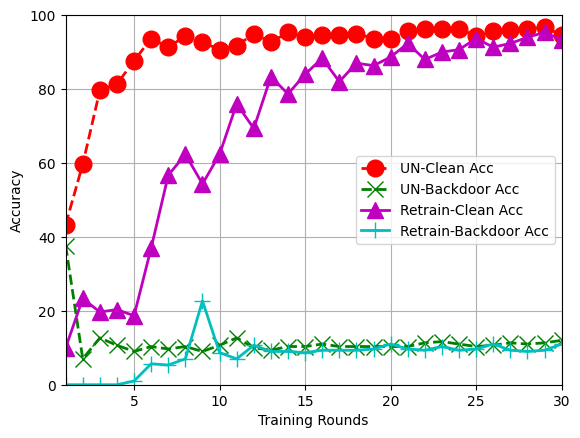

In [19]:
import matplotlib.pyplot as plt

fl_rounds = [i for i in range(1, num_fl_rounds + 1)]

plt.plot(fl_rounds, clean_accuracy_unlearn_fl_after_unlearn['Unlearn'], 'ro--', linewidth=2, markersize=12, label='UN-Clean Acc')
plt.plot(fl_rounds, pois_accuracy_unlearn_fl_after_unlearn['Unlearn'], 'gx--', linewidth=2, markersize=12, label='UN-Backdoor Acc') 
plt.plot(fl_rounds, clean_accuracy_unlearn_fl_after_unlearn['Retrain'], 'm^-', linewidth=2, markersize=12, label='Retrain-Clean Acc')
plt.plot(fl_rounds, pois_accuracy_unlearn_fl_after_unlearn['Retrain'], 'c+-', linewidth=2, markersize=12, label='Retrain-Backdoor Acc')
plt.xlabel('Training Rounds')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim([0, 100])
plt.xlim([1, 30])
plt.legend()
plt.savefig("Unlearning.png")
plt.show()